# LDA2Vec
Adapted from tensorflow implementation: 

(Current) https://github.com/nateraw/Lda2vec-Tensorflow

(Old) https://github.com/meereeum/lda2vec-tf

(Original) https://github.com/cemoody/lda2vec

In [1]:
import pandas as pd
import numpy as np
import pyLDAvis
import pickle
import random

In [2]:
import sys
sys.path.append('./Lda2vec-Tensorflow-master')

In [3]:
from lda2vec import *

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0Metal device set to: Apple M1



## Find Ending Index of Documents for Each Year

In [5]:
data = pd.read_csv("papers.csv")

In [6]:
data = data[data["paper_text"].notnull()]

In [7]:
data = data.sort_values(by=["year"], kind='mergesort')

In [8]:
years = list(data["year"].unique())
counts = list(data["year"].value_counts())[::-1]
for i in range(1,len(counts)):
  counts[i] += counts[i-1]
year_index = {years[i]:counts[i] for i in range(len(years))}

In [9]:
year_index

{1987: 90,
 1988: 184,
 1989: 285,
 1990: 412,
 1991: 552,
 1992: 695,
 1993: 839,
 1994: 989,
 1995: 1139,
 1996: 1290,
 1997: 1442,
 1998: 1594,
 1999: 1746,
 2000: 1904,
 2001: 2101,
 2002: 2299,
 2003: 2503,
 2004: 2710,
 2005: 2917,
 2006: 3124,
 2007: 3341,
 2008: 3591,
 2009: 3853,
 2010: 4145,
 2011: 4451,
 2012: 4811,
 2013: 5179,
 2014: 5582,
 2015: 5993,
 2016: 6562,
 2017: 7241}

## Preprocessing

$\tt cleaned.txt$ is a txt file with all NIPS papers with all stop words and words with $\rm{length} \leq 3$ removed.

Preprocess incorporates tokenization (splitting sentences into words), creating a vocabulary to save mappings from tokens to integer indices, and generating skip-grams.

In [14]:
df = pd.read_csv("cleaned.txt")

In [15]:
df = df[3341:] # Use only 2008-2017 papers

In [16]:
papers = random.sample(list(range(3341,7241)), 300)
papers.sort()

In [17]:
select = df.loc[papers, 'stop_removed_paper_text']

In [18]:
groupList = []
for i in range(100):
    temp = pd.DataFrame()
    temp['stop_removed_paper_text'] = [select.iloc[i*3] + select.iloc[i*3+1] + select.iloc[i*3+2]]
    groupList.append(temp)

In [19]:
aggregate = pd.concat(groupList, ignore_index=True)

In [20]:
aggregate

,stop_removed_paper_text
0,efficient inference phylogenetic indel trees a...
1,multiscale random fields application contour g...
2,estimating vector fields using sparse basis fi...
3,extended level method efficient multiple kerne...
4,clusters coarse partitions relaxations david s...
...,...
95,decentralized algorithms outperform centralize...
96,hierarchical implicit models likelihood free v...
97,learning error analysis structured prediction ...
98,causal effect inference deep latent variable m...


In [21]:
# Initialize a preprocessor
P = nlppipe.Preprocessor(aggregate, "stop_removed_paper_text", max_features=30000, maxlen=10000, min_count=30)

/Users/keanl/miniforge3/lib/python3.9/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [22]:
# Run the preprocessing on your dataframe
P.preprocess()


---------- Tokenizing Texts ----------


100it [01:56,  1.16s/it]


Removing 24607 low frequency tokens out of 27906 total tokens

---------- Getting Skipgrams ----------


100it [00:06, 14.65it/s]


In [23]:
# Should we load pretrained embeddings from file
load_embeds = True

# Load embeddings from file if we choose to do so
if load_embeds:
    # Load embedding matrix from file path - change path to where you saved them
    embedding_matrix = P.load_glove("glove.6B.300d.txt")
else:
    embedding_matrix = None

/Users/keanl/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
# Save data to data_dir
P.save_data("aggregate4", embedding_matrix=embedding_matrix)

## Using the LDA2Vec Model

Using the LDA2Vec model on preprocessed data.

In [5]:
# Path to preprocessed data
data_path  = "aggregate4"
# Whether or not to load saved embeddings file
load_embeds = True

# Load data from files
(idx_to_word, word_to_idx, freqs, pivot_ids,
 target_ids, doc_ids, embed_matrix) = utils.load_preprocessed_data(data_path, load_embed_matrix=load_embeds)

In [6]:
# Number of unique documents
num_docs = doc_ids.max() + 1
# Number of unique words in vocabulary (int)
vocab_size = len(freqs)
# Embed layer dimension size
# If not loading embeds, change 128 to whatever size you want.
embed_size = embed_matrix.shape[1] if load_embeds else 128
# Number of topics to cluster into
num_topics = 40
# Amount of iterations over entire dataset
num_epochs = 40
# Batch size - Increase/decrease depending on memory usage
batch_size = 4096
# Epoch that we want to "switch on" loss_lda
switch_loss_epoch = 0
# Pretrained embeddings value
pretrained_embeddings = embed_matrix if load_embeds else None
# If True, save logdir, otherwise don't
save_graph = False

In [7]:
# Initialize the model
m = model(num_docs,
          vocab_size,
          num_topics,
          embedding_size=embed_size,
          pretrained_embeddings=pretrained_embeddings,
          freqs=freqs,
          batch_size = batch_size,
          save_graph_def=save_graph)


EPOCH: 1
LOSS 10.167232 w2v 4.784438 lda 4.118317 reg 1.2644112

EPOCH: 2
LOSS 9.16579 w2v 4.8441234 lda 3.2861655 reg 1.0352569

EPOCH: 3
LOSS 8.306377 w2v 4.9852114 lda 2.702922 reg 0.6180591

EPOCH: 4
LOSS 7.3331575 w2v 4.713829 lda 2.3632653 reg 0.25581333

EPOCH: 5
LOSS 6.9471345 w2v 4.6686783 lda 2.1887214 reg 0.089725
Instructions for updating:
keep_dims is deprecated, use keepdims instead
---------Closest 10 words to given indexes----------
Topic 0 : saddle, hessian, decompositions, newton, minima, regularizer, recht, comput, quasi, decomposition
Topic 1 : adept, interestingly, selection, selects, conversely, attention, responses, importantly, cmab, hyperparameter
Topic 2 : unfortunately, trend, researchers, encourage, hope, noted, follow, longer, beginning, tends
Topic 3 : interestingly, mode, circle, frobenius, family, norm, readily, origin, written, introduced
Topic 4 : interestingly, additionally, iteration, refer, agents, acknowledgements, primitive, adapted, trajectories

LOSS 7.098512 w2v 5.0495806 lda 2.0469325 reg 0.00200418

EPOCH: 12
LOSS 6.1558094 w2v 4.1073885 lda 2.0469685 reg 0.0014461583

EPOCH: 13
LOSS 6.612478 w2v 4.564354 lda 2.0470204 reg 0.0011081746

EPOCH: 14
LOSS 6.1454015 w2v 4.098072 lda 2.0466058 reg 0.00072354096

EPOCH: 15
LOSS 6.8971167 w2v 4.8498535 lda 2.0465667 reg 0.00069920963
---------Closest 10 words to given indexes----------
Topic 0 : wright, attractive, saddle, recht, contrastive, eigen, minima, posed, indefinite, subproblem
Topic 1 : subsequently, utilizes, schmidhuber, contrast, competitive, richard, graves, paninski, extended, inferior
Topic 2 : encourage, bach, objectives, penalized, correctly, stopping, assignment, unfortunately, encourages, inducing
Topic 3 : frobenius, operator, stein, admits, convenience, fairly, replaced, mode, spectral, schatten
Topic 4 : mcvi, purpose, stephen, applies, successive, longer, followed, cores, position, smith
Topic 5 : stages, annotations, measurement, resnet, majority, pipeline,

LOSS 6.7546086 w2v 4.712996 lda 2.0413542 reg 0.00026069535

EPOCH: 22
LOSS 6.2614675 w2v 4.220506 lda 2.0407238 reg 0.00023782719

EPOCH: 23
LOSS 6.149824 w2v 4.1098986 lda 2.039707 reg 0.00021768201

EPOCH: 24
LOSS 5.8954864 w2v 3.856693 lda 2.0385847 reg 0.00020860982

EPOCH: 25
LOSS 6.4978814 w2v 4.4598565 lda 2.0378535 reg 0.0001711923
---------Closest 10 words to given indexes----------
Topic 0 : wright, contrastive, adept, discretization, saddle, yang, california, yann, backpropagation, preprint
Topic 1 : note, level, final, shows, neural, contrast, respectively, vincent, given, sutskever
Topic 2 : bach, encourage, objectives, usual, thought, eccv, correctly, grants, early, accelerated
Topic 3 : admits, dean, replaced, daniel, couplings, attains, fairly, operator, appgrad, algebra
Topic 4 : nnpca, stephen, note, consider, time, learning, given, following, represented, input
Topic 5 : large, opposed, scale, note, perceptron, performed, measurement, image, contrast, small
Topic 6 

LOSS 6.000755 w2v 3.9681087 lda 2.032501 reg 0.00014617718

EPOCH: 32
LOSS 5.654261 w2v 3.622526 lda 2.0315976 reg 0.00013712884

EPOCH: 33
LOSS 5.935931 w2v 3.9049635 lda 2.0308394 reg 0.00012866677

EPOCH: 34
LOSS 6.4722977 w2v 4.442049 lda 2.0301154 reg 0.00013280238

EPOCH: 35
LOSS 6.145411 w2v 4.1158695 lda 2.0294023 reg 0.00013918245
---------Closest 10 words to given indexes----------
Topic 0 : wright, adept, yann, columbia, neural, evaluated, smola, yang, rmse, california
Topic 1 : note, given, shows, analysis, results, learning, level, different, respectively, following
Topic 2 : bach, editors, given, objectives, particular, find, example, learning, finally, encourage
Topic 3 : appgrad, dean, admits, couplings, daniel, likelihoods, kakade, mellon, carnegie, schatten
Topic 4 : learning, time, training, given, consider, following, nnpca, left, represented, input
Topic 5 : large, learning, performed, scale, note, image, example, approach, algorithm, compared
Topic 6 : estimating,

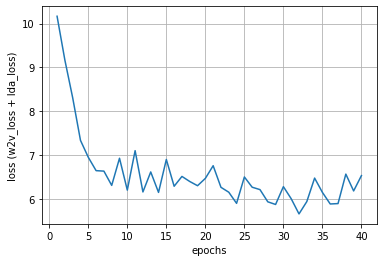

In [8]:
# Train the model
m.train(pivot_ids,
        target_ids,
        doc_ids,
        len(pivot_ids),
        num_epochs,
        idx_to_word=idx_to_word,
        switch_loss_epoch=switch_loss_epoch)

## Get Word and Topic Embeddings

Visualize topics

In [9]:
idx_to_word

{1: 'learning',
 2: 'model',
 3: 'algorithm',
 4: 'data',
 5: 'function',
 6: 'time',
 7: 'number',
 8: 'problem',
 9: 'models',
 10: 'figure',
 11: 'based',
 12: 'results',
 13: 'distribution',
 14: 'method',
 15: 'given',
 16: 'matrix',
 17: 'methods',
 18: 'information',
 19: 'training',
 20: 'neural',
 21: 'algorithms',
 22: 'probability',
 23: 'random',
 24: 'different',
 25: 'network',
 26: 'optimal',
 27: 'case',
 28: 'large',
 29: 'section',
 30: 'linear',
 31: 'approach',
 32: 'theorem',
 33: 'gradient',
 34: 'optimization',
 35: 'performance',
 36: 'bound',
 37: 'space',
 38: 'analysis',
 39: 'parameters',
 40: 'state',
 41: 'work',
 42: 'image',
 43: 'error',
 44: 'following',
 45: 'features',
 46: 'functions',
 47: 'example',
 48: 'networks',
 49: 'inference',
 50: 'order',
 51: 'machine',
 52: 'value',
 53: 'point',
 54: 'samples',
 55: 'sample',
 56: 'stochastic',
 57: 'loss',
 58: 'size',
 59: 'process',
 60: 'rate',
 61: 'convex',
 62: 'consider',
 63: 'problems',
 64: 

In [10]:
doc_embed = m.sesh.run(m.mixture.doc_embedding)

In [11]:
topic_embed = m.sesh.run(m.mixture.topic_embedding)

In [12]:
word_embed = m.sesh.run(m.w_embed.embedding)

In [13]:
# Extract all unique words in order of index 0-vocab_size
vocabulary = []
for k,v in idx_to_word.items():
    vocabulary.append(v)

In [14]:
doc_lengths = np.load("aggregate4/doc_lengths.npy")

In [15]:
vis_data = utils.prepare_topics(doc_embed, topic_embed, word_embed, np.array(vocabulary), doc_lengths=doc_lengths,
                              term_frequency=freqs, normalize=True)

In [16]:
prepared_vis_data = pyLDAvis.prepare(**vis_data)

/Users/keanl/miniforge3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/keanl/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/keanl/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/keanl/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/keanl/miniforge3/lib/python3.9/site-packages/pa

In [17]:
pyLDAvis.display(prepared_vis_data)

In [18]:
norm_topic = topic_embed / np.reshape(np.linalg.norm(topic_embed, axis=1), (topic_embed.shape[0], 1))
norm_word = word_embed / np.reshape(np.linalg.norm(word_embed, axis=1), (word_embed.shape[0], 1))
cosine = np.dot(norm_topic, norm_word.T)

In [19]:
sim_idx = np.argsort(cosine, kind='stable')

In [20]:
idxs = np.zeros((sim_idx.shape[0],10))
for i in range(sim_idx.shape[0]):
    idxs[i] = sim_idx[i][-10:]

In [21]:
coherence = 0
count = 0
for i in range(idxs.shape[0]):
    for j in range(idxs.shape[1]-1):
        for k in range(j+1, idxs.shape[1]):
            count += 1
            coherence += np.dot(norm_word[int(idxs[i][j])], norm_word[int(idxs[i][k])].T)
print(f"Overall Coherence: {coherence/count}")

Overall Coherence: 0.3831858639488928


In [22]:
np.save("doc_embed_a4.npy", doc_embed)

In [23]:
np.save("word_embed_a4.npy", word_embed)

In [24]:
np.save("topic_embed_a4.npy", topic_embed)